In [34]:
import numpy as np
from datetime import datetime
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
import math
import torch as T
from torch.autograd import Variable
import numpy as np
import pdb
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
!pip install torchsummaryX --quiet
from torchsummaryX import summary as summaryX
from torchsummary import summary
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),

    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

)

def prepare_data(data):
  seq_data=[]
  seq_label=[]
  k=1
  temp_data=[]
  temp_label=[]
  ends=5
  alpha=9
  total=3*alpha+2*ends
  for image,label in data:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`

    temp_label.append(label)
    if k%4==1:
      for i in range(1,alpha+1,2):
        temp_data.append(image*0.1*(i))

      temp_data.append(image)

      for i in range(alpha):
        temp_data.append(image*0.1*(alpha-i))

    elif k%4==0:
      temp_data.append(image)
      l = len(temp_data)
      for i in range(alpha):
        temp_data[l-alpha+i]=temp_data[l-alpha+i]+image*0.1*(i)

        if (i+1)%2==1:
          temp_data.append(image*0.1*(alpha-i))
      seq_data.append(temp_data)
      seq_label.append(temp_label)
      temp_data=[]
      temp_label=[]
    else:
      l = len(temp_data)
      temp_data.append(image)
      for i in range(alpha):
        temp_data[l-alpha+i]=temp_data[l-alpha+i]+image*0.1*(i)
        temp_data.append(image*0.1*(alpha-i))
    k=k+1
  return seq_data, seq_label
train_seq_image, train_seq_label = prepare_data(train_data)
test_seq_image, test_seq_label = prepare_data(test_data)


100%|██████████| 9912422/9912422 [00:00<00:00, 87663830.50it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23840915.93it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26396431.30it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3961432.47it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
test_seq_label[0]

[7, 2, 1, 0]

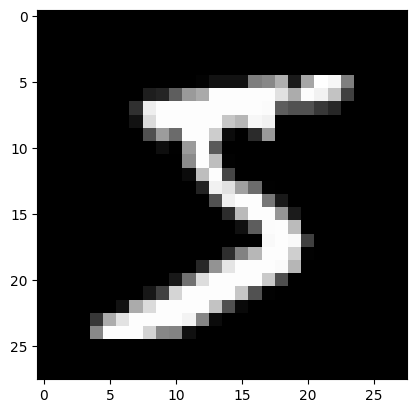

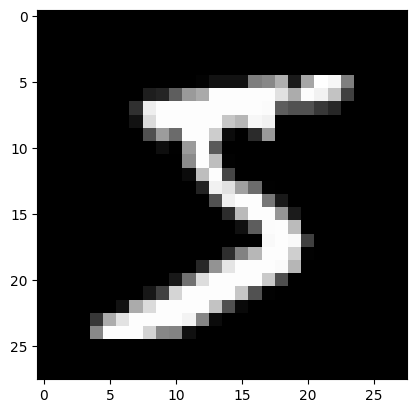

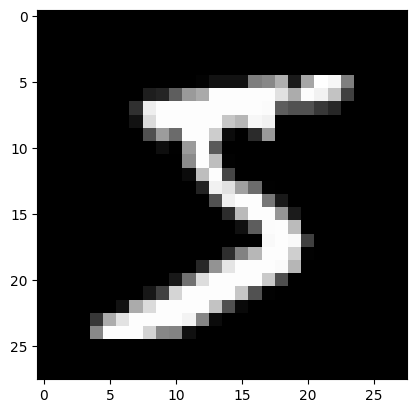

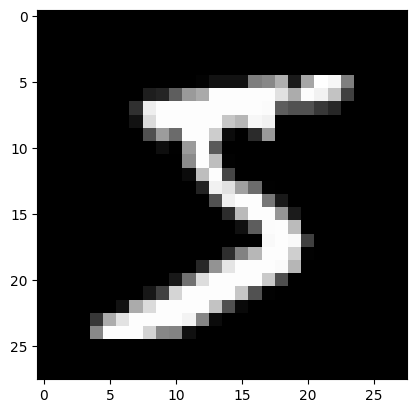

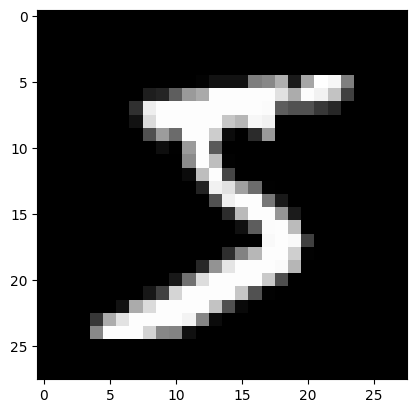

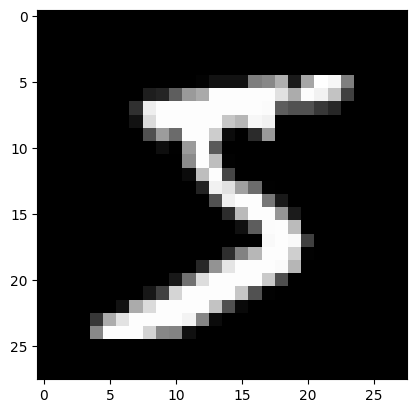

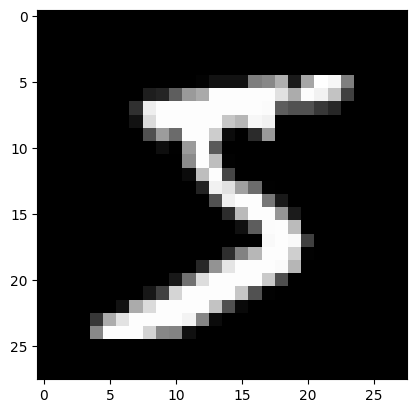

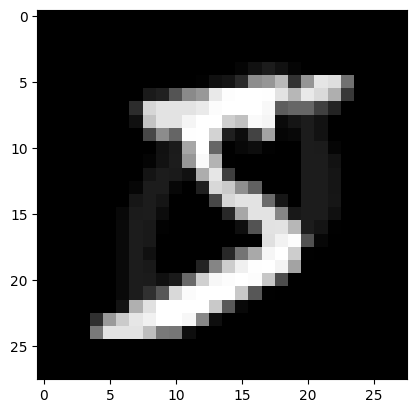

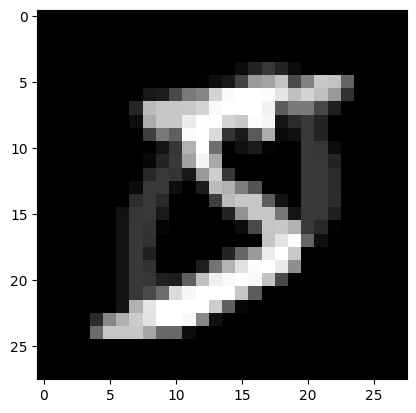

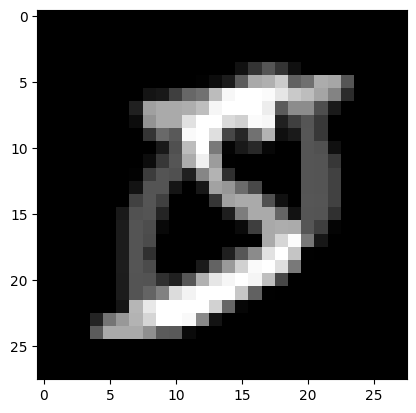

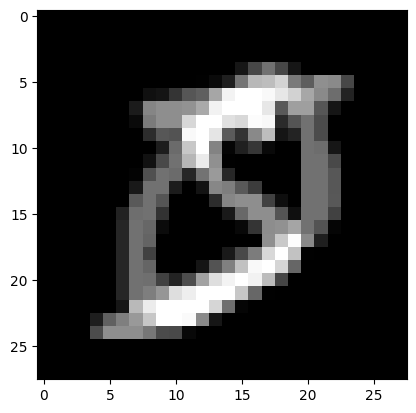

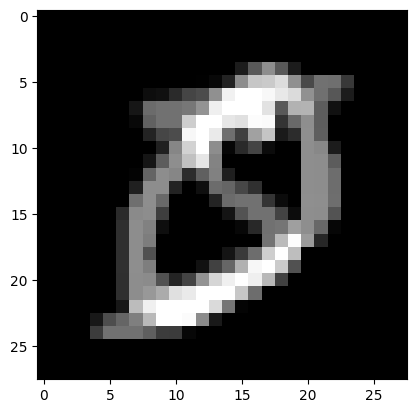

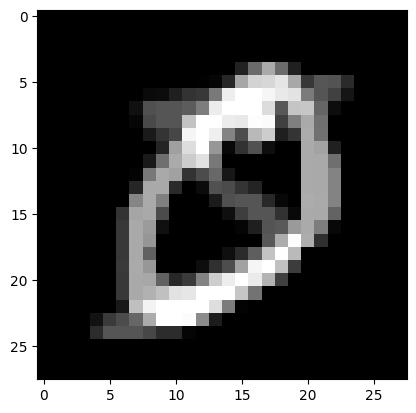

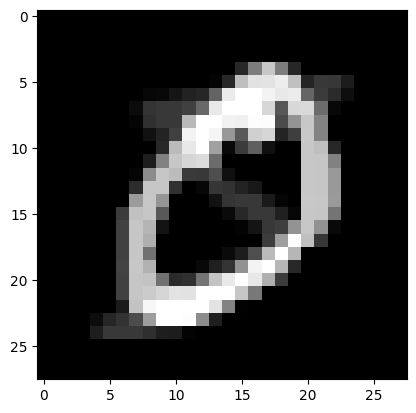

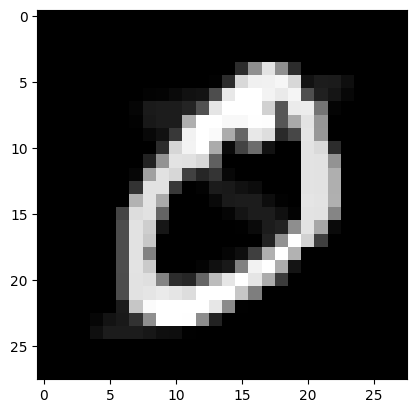

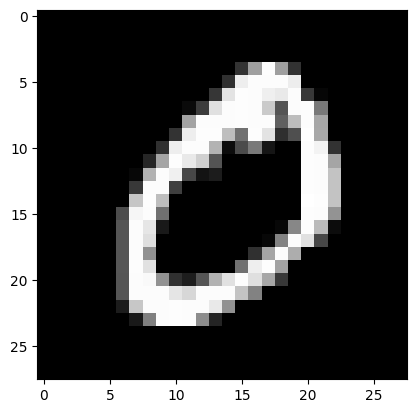

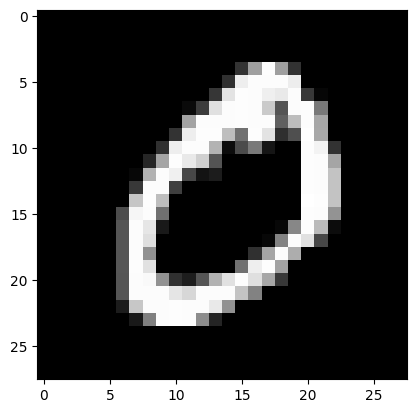

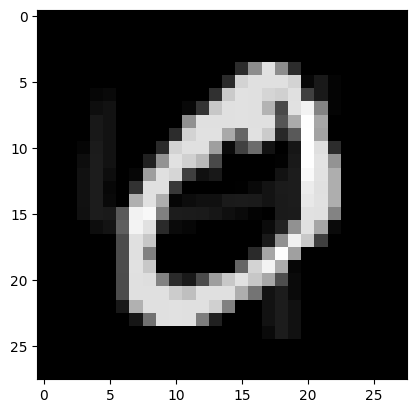

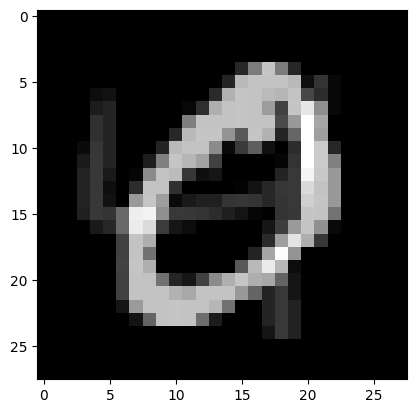

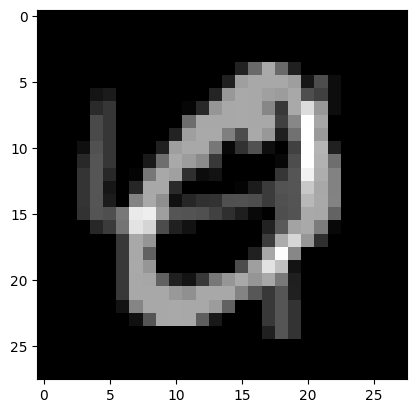

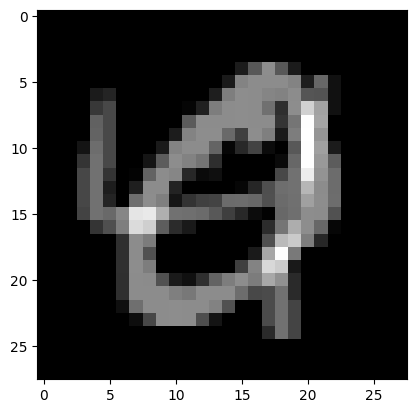

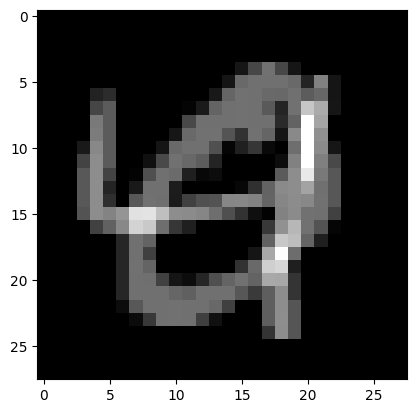

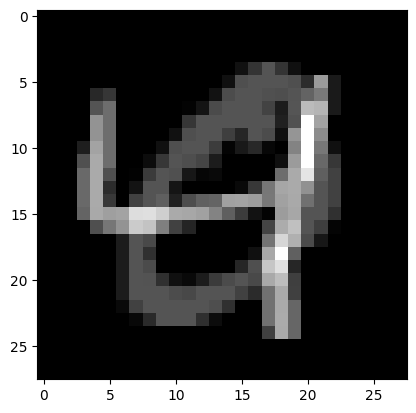

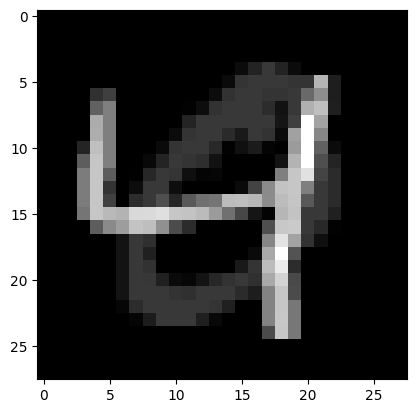

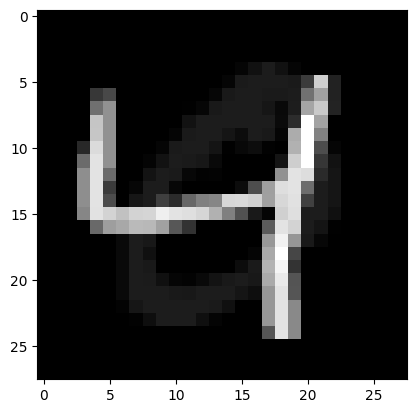

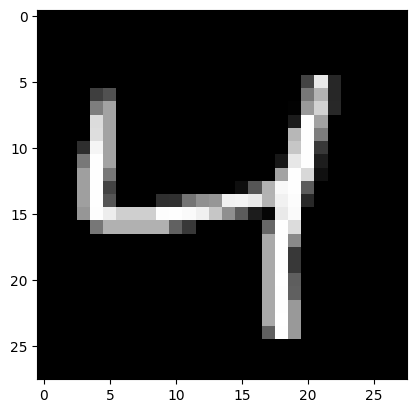

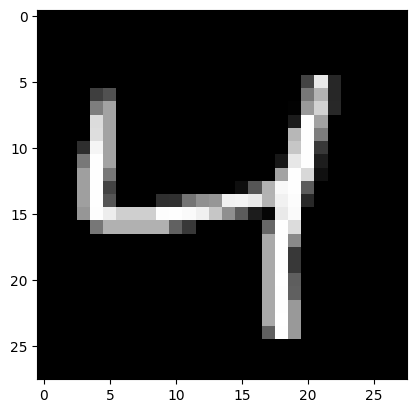

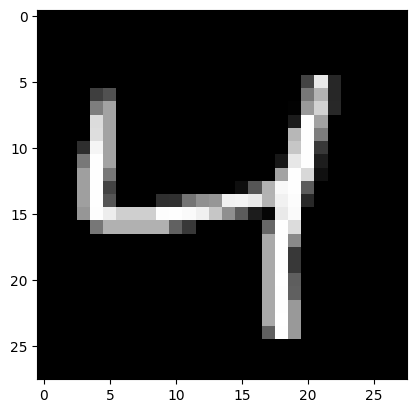

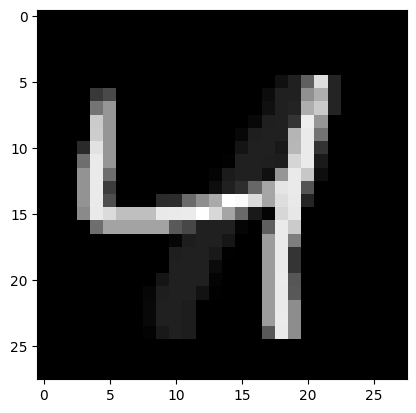

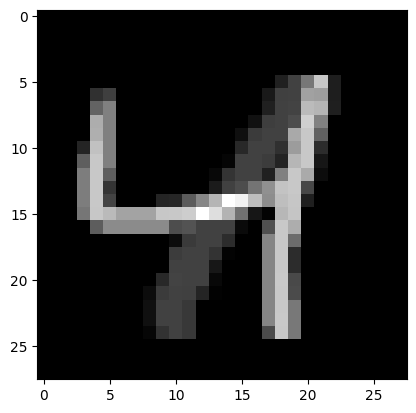

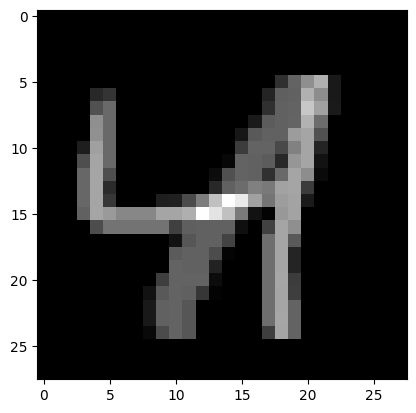

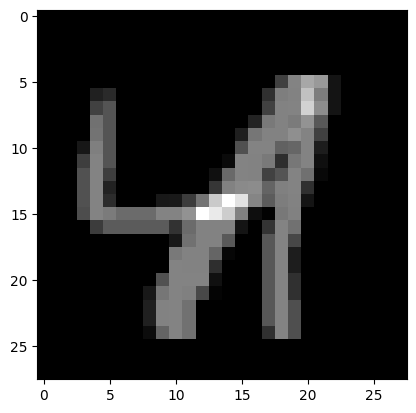

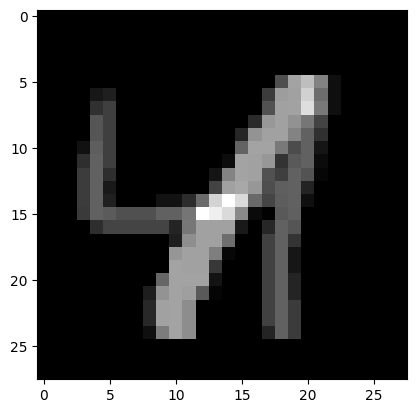

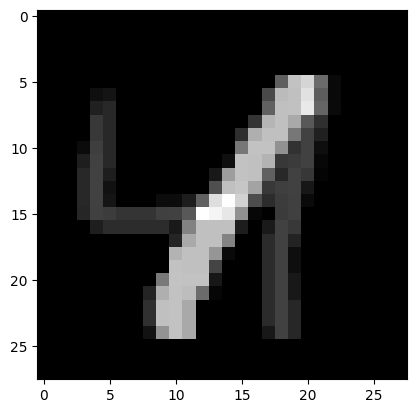

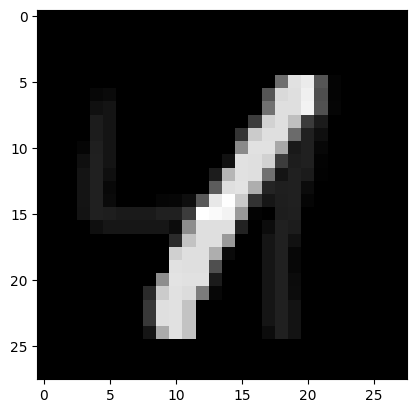

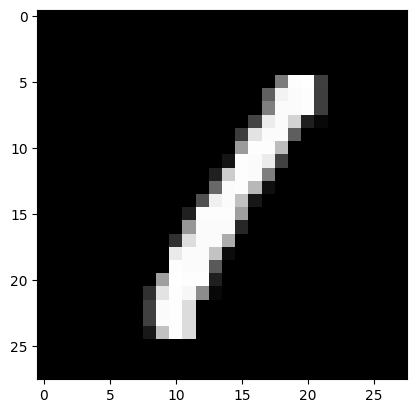

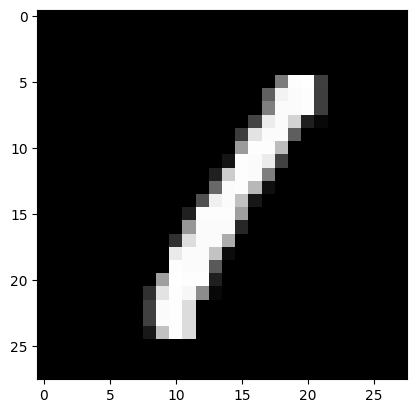

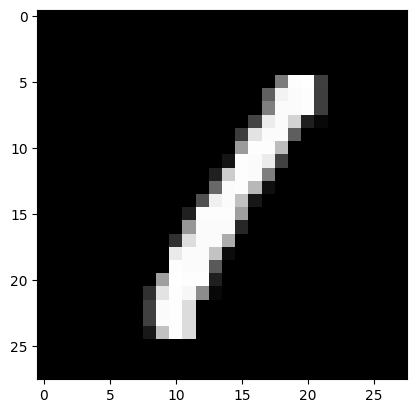

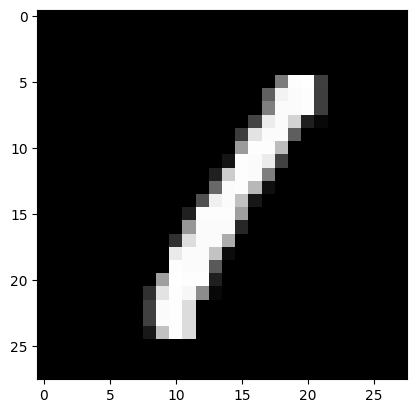

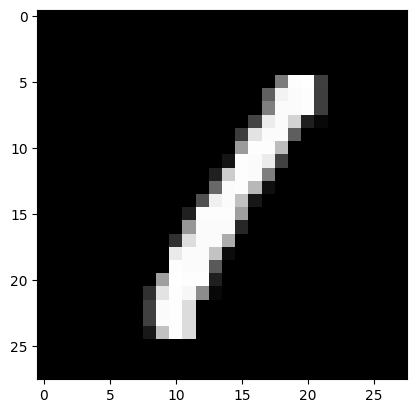

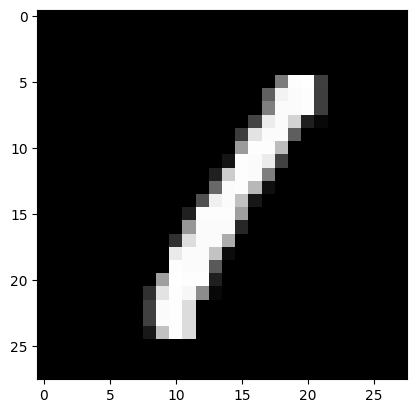

In [42]:

for i in seq_data[0]:
  plt.imshow(i.reshape(28,28), cmap='gray')
  plt.show()

In [35]:
class LeNetpp(nn.Module):
    def __init__(self):
        super(LeNetpp, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten())

        self.fc = nn.Linear(2048, 3)
        self.relu = nn.PReLU()
        self.fc2 = nn.Linear(3,11)
        self.softmax= nn.Softmax()


    def forward(self, x):
        out = self.layer1(x)
        print("output.shape : ",out.shape)
        out = self.layer2(out)
        print("output.shape : ",out.shape)
        out = self.layer3(out)
        print("output.shape : ",out.shape)
        out = self.fc(out)
        v = self.relu(out)
        print("output.shape : ",out.shape)
        f = self.fc2(v)
        out = self.softmax(f)
        print("output.shape : ",out.shape)


        return out, v,f

In [42]:
model = LeNetpp()

x = torch.randn(64,1,32,32)
output,_ = model(x)

print("output.shape : ",output.shape)
print(model.fc2.weight.shape)

output.shape :  torch.Size([64, 32, 16, 16])
output.shape :  torch.Size([64, 64, 8, 8])
output.shape :  torch.Size([64, 2048])
output.shape :  torch.Size([64, 3])
output.shape :  torch.Size([64, 11])
output.shape :  torch.Size([64, 11])
torch.Size([11, 3])


<ipython-input-35-a7c9d063030b>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


In [ ]:
def ctc_loss_base(pred, token):
    '''
    :param pred: (Time, batch, voca_size+1)
    :param pred_len: (batch)
    :param token: (batch, U)
    :param token_len: (batch)
    '''
    Time, batch, L= pred.size(0), pred.size(1), pred.size(2)
    U = token.size(1)

    pred_token=pred[:,:,0]

    for i in range(2*U):

      if i%2==1:
        pred_token.append(pred[:,:,0])
      else:
        pred_token.append(pred[:,token[:,int(i/2)]])
    alpha=np.zeros(pred.shape)

    for t in range(Time):
      for s in range(2*U+1):
        if s==0 and t==0:
          alpha[0,:,0]=pred_token[0,:,0]
        elif s==1 and t==0:
          alpha[0,:,1]=pred_token[0,:,1]
        else:
          if s %2==0:
            if t>0:
              if s>0:
                alpha[t,:,s] = (alpha[t-1,:,s]+ alpha[t-1,:,s-1])*pred_token[t,:,s]
              else:
                alpha[t,:,s] = (alpha[t-1,:,s])*pred_token[t,:,s]
          else:
            if s>2
              if t>1:
                mask = token[:,int((s-1)/2)]==token[:,int((s-3)/2)]
                alpha[t,mask,s] = (alpha[t-1,mask,s]+ alpha[t-1,mask,s-1])*pred_token[t,mask,s]
                alpha[t,~mask,s] = (alpha[t-1,~mask,s]+alpha[t-1,~mask,s-1]+alpha[t-2,~mask,s-2])*pred_token[t,~mask,s]
              elif t>0:
                alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1])*pred_token[t,:,s]

            else:

              if t<1:
                alpha[t,:,s] = 0
              elif s<1:
                alpha[t,:,s] = (alpha[t-1,:,s])*pred_token[t,:,s]
              elif t<2 or s<2:
                alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1])*pred_token[t,:,s]
              else:
                alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1]+alpha[t-2,:,s-2])*pred_token[t,:,s]

    beta = np.zeros(pred.shape)
    for tr in range(Time):
      for sr in range(2*U+1):
        t=Time-1-tr
        s=2*U-sr
        if s==2*U and t==Time-1:
          beta[s,:,t]=1
        elif s==2*U-1 and t==Time-1:
          beta[s,:,t]=1
        else:
          if s %2==0:
            if t<Time-1:
              if s<2*U:
                beta[t,:,s] = (beta[t+1,:,s]*pred_token[t,:,s]+ beta[t+1,:,s+1]*pred_token[t,:,s+1])
              else:
                beta[t,:,s] = (beta[t+1,:,s])*pred_token[t,:,s]
          else:
            if s<2*U-1 and t<Time-2:

              mask = token[:,int((s-1)/2)]==token[:,int((s+1)/2)]
              beta[t,mask,s] = (beta[t+1,mask,s]+ beta[t+1,mask,s+1])*pred_token[t,mask,s]
              beta[t,~mask,s] = (beta[t+1,~mask,s]+beta[t+1,~mask,s+1]+beta[t+2,~mask,s+2])*pred_token[t,~mask,s]
            else:
              if  t<Time-1:
                if s<2*U:
                  beta[t,:,s] = (beta[t+1,:,s]*pred_token[t,:,s]+ beta[t+1,:,s+1]*pred_token[t,:,s+1])
                else:
                  beta[t,:,s] = (beta[t+1,:,s])*pred_token[t,:,s]

    gamma=beta*alpha/pred_token

    return gamma,pred_token

In [22]:
def ctc_loss(pred, token, beta, lamda1,lamda2,model):
  gamma,_,_=ctc_loss_base(pred,token)
  p_seq= np.sum(gamma,axis=2)
  loss=np.sum(-math.log(p_seq),axis=0)

[False  True  True False False]


In [23]:
def radialctc_loss(pred, token,n,T,beta,lamda1,lamda2,model):
  gamma,pred_token,f=ctc_loss_base(pred,token)
  Time, batch, L= pred.size(0), pred.size(1), pred.size(2)
  U = token.size(1)
  k=U+1+math.floor((T-U)*n)
  theta=np.arccos(f)
  m=np.sort(theta[:,:,1:]-theta[:,:,0],axis=2)
  m=m[:,:,k]
  z=np.zeros(f.shape)
  z[:,:,0]=np.exp(math.cos(theta[:,:,0]+m))/(np.exp(math.cos(theta[:,:,0]+m))+ np.sum(np.exp(math.cos(theta[:,:,1:])),axis=2))
  z[:,:,1:]=np.exp(math.cos(theta[:,:,1:]))/(np.exp(math.cos(theta[:,:,0]+m))+ np.sum(np.exp(math.cos(theta[:,:,1:])),axis=2))
  z_token=z[:,:,0]

  for i in range(2*U):

    if i%2==1:
      z_token.append(z[:,:,0])
    else:
      z_token.append(z[:,token[:,int(i/2)]])
  c=0
  weights=model.fc2.weigh.detach().numpy()
  loss=np.sum(np.sum(-math.log(gamma)*z_token,axis=2),axis=0)+lamda1*np.sum(np.dot(weights[0,:],weights[1:,:].T)-math.cos(beta))+lamda2*c


In [51]:
def train(model, optimizer, epochs, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  for epoch in range(epochs):
    for i in range(len(train_seq_image)):
      # Our batch:
      inputs = train_seq_image[i]

      labels=train_seq_label[i]

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs,_,_ = model(inputs)

      # Calculate loss
      loss = ctc_loss(model,outputs, labels, 0.2*math.pi,1,1)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

array([-0.10422017, -0.03420781, -0.14579648,  0.17195779,  0.03661408,
        0.07689232, -0.14340737, -0.09135307, -0.14650412,  0.167819  ],
      dtype=float32)

In [15]:
import torch.optim as optim

model = LeNetpp()


optimizer = optim.Adagrad(model.parameters(), lr=1e-3)


epochs = 64
loss_history = train(model, optimizer, 30)

(6, 3, 3, 3)